# 迴歸(Regression)與時間序列(Time Series) 比較

## 載入相關套件

In [3]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [65]:
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

# 忽略所有警告
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Arial'

## 載入資料集

In [66]:
import yfinance as yf
from datetime import date
today = date.today().strftime("%Y-%m-%d")
df = yf.download('2330.TW', start="2015-09-01", end="2023-09-01")
df.head()
#用Adj Date


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-09-01,127.5,127.5,124.0,124.0,97.794754,42340000
2015-09-02,123.0,127.0,123.0,125.5,98.977768,36973000
2015-09-03,127.5,127.5,125.0,127.0,100.160744,24004000
2015-09-04,126.5,127.0,123.5,125.0,98.583427,22006000
2015-09-07,124.5,126.0,122.0,122.5,96.611755,25891000


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1949 entries, 2015-09-01 to 2023-08-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1949 non-null   float64
 1   High       1949 non-null   float64
 2   Low        1949 non-null   float64
 3   Close      1949 non-null   float64
 4   Adj Close  1949 non-null   float64
 5   Volume     1949 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 106.6 KB


## 資料轉換

In [68]:
df_new = df[['Adj Close']].copy()
df_new.columns = ['Close']
df_new.head

<bound method NDFrame.head of                  Close
Date                  
2015-09-01   97.794754
2015-09-02   98.977768
2015-09-03  100.160744
2015-09-04   98.583427
2015-09-07   96.611755
...                ...
2023-08-25  542.972290
2023-08-28  545.955627
2023-08-29  548.939026
2023-08-30  551.922363
2023-08-31  545.955627

[1949 rows x 1 columns]>

## 繪圖

<Axes: xlabel='Date', ylabel='Close'>

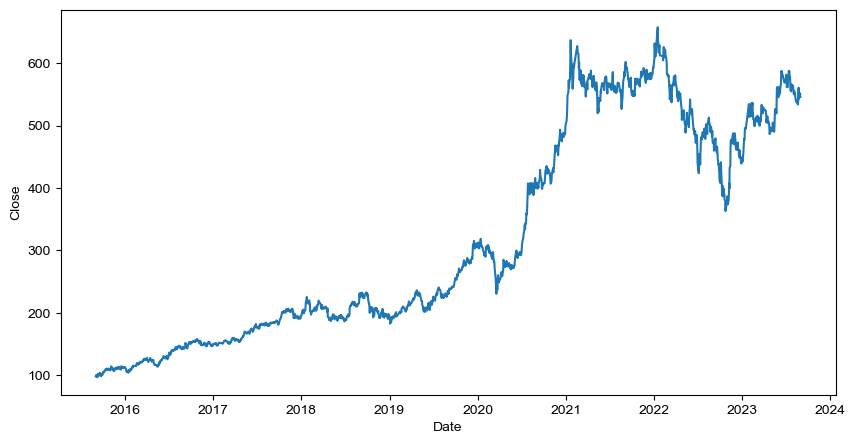

In [69]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=df.index, y='Close', data=df_new)


## 迴歸(Regression)

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lr = LinearRegression()
# X = df.index.astype(str).map(lambda x:x[:4]+x[5:7]).values.reshape(df.shape[0], -1)
X = np.arange(df_new.shape[0]).reshape(-1, 1)
y = df['Close']
lr.fit(X, y)
pred = lr.predict(X)
print('MSE =', mean_squared_error(y, pred))

MSE = 5177.876057718501


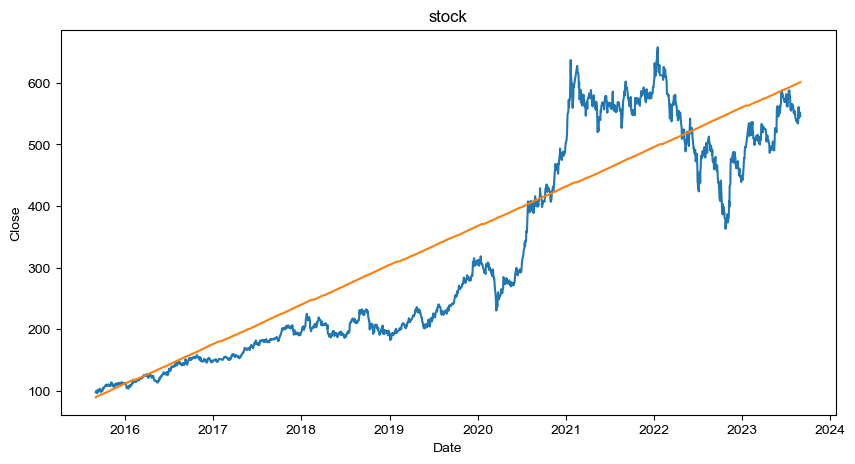

In [71]:
# 實際樣本點
plt.figure(figsize=(10, 5))
sns.lineplot(x=df.index, y='Close', data=df_new)
plt.title('stock')

# 預測迴歸線
plt.plot(df.index, pred);

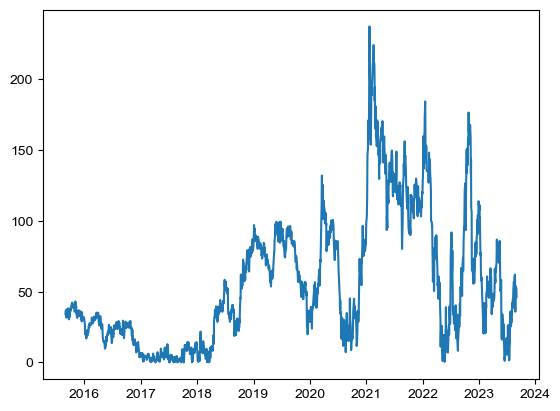

In [72]:
# 殘差線圖
plt.plot(df_new.index, np.abs(df['Close'] - pred));

## 近年股價過大，與過去脫節，只擷取短期資料分析

In [73]:
df3 = df_new.query('index > "2019-01-01" and Close > 400')
df3.head()

,Close
Date,
2020-07-28,407.542145
2020-07-30,406.605347
2020-08-05,401.920959
2020-08-06,407.542145
2020-08-07,405.668427


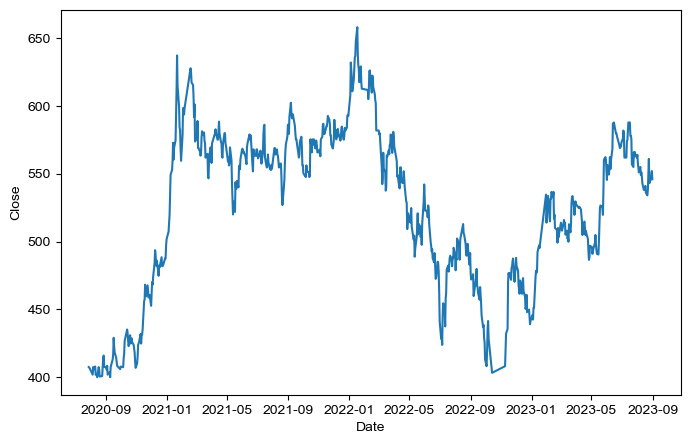

In [74]:
# 實際樣本點
plt.figure(figsize=(8, 5))
sns.lineplot(x=df2.index, y='Close', data=df3);

## 定態測試(Augmented Dickey–Fuller Test for Stationarity)

In [75]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df3['Close'])
print(F'ADF統計量: {result[0]}\np value: {result[1]}' + \
      f'\n滯後期數(Lags): {result[2]}\n資料筆數: {result[3]}')

ADF統計量: -2.592368376234808
p value: 0.09458484970028563
滯後期數(Lags): 1
資料筆數: 721


## 結論：p > 0.05 ==> 非定態

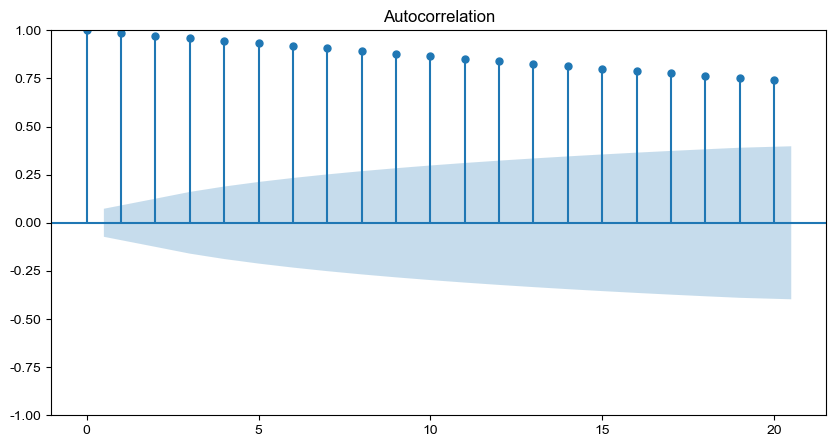

In [76]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plot_acf(df3['Close'], lags=20)
fig.set_size_inches(10, 5)

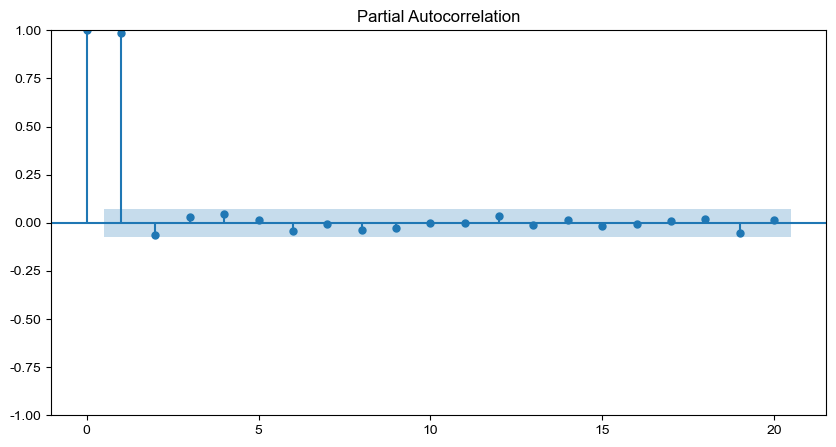

In [77]:
fig = plot_pacf(df3['Close'], lags=20, method='ywm')
fig.set_size_inches(10, 5)

#

## 時間序列(Time Series)

In [78]:
from statsmodels.tsa.arima.model import ARIMA

# 建立時間序列資料
series = df3.copy()

# AR(1) 模型訓練 
ar = ARIMA(df3, order=(1,0,0))
model = ar.fit()

# 顯示模型訓練報告
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  723
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2564.040
Date:                Sun, 17 Sep 2023   AIC                           5134.080
Time:                        08:23:54   BIC                           5147.831
Sample:                             0   HQIC                          5139.388
                                - 723                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        513.9445     25.240     20.363      0.000     464.476     563.413
ar.L1          0.9908      0.005    218.398      0.000       0.982       1.000
sigma2        70.0604      2.847     24.606      0.0

In [79]:
model.params

const     513.944460
ar.L1       0.990807
sigma2     70.060352
dtype: float64

In [80]:
df['Close'].mean()

345.50820933812213

## 繪圖比較實際值與預測值

In [81]:
model.fittedvalues

Date
2020-07-28    513.944460
2020-07-30    408.520313
2020-08-05    407.592127
2020-08-06    402.950804
2020-08-07    408.520313
                 ...    
2023-08-25    560.441083
2023-08-28    542.705434
2023-08-29    545.661345
2023-08-30    548.617317
2023-08-31    551.573228
Length: 723, dtype: float64

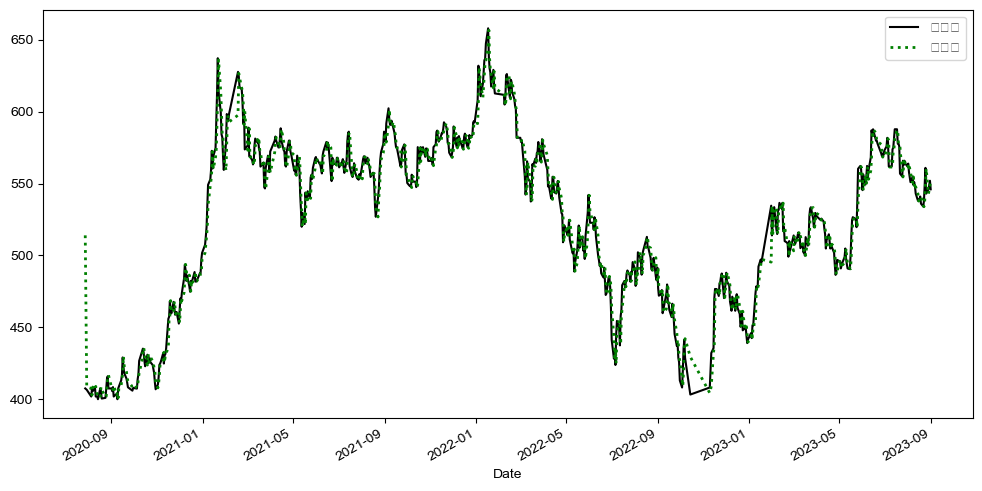

In [87]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Arial']

series['Close'].plot(figsize=(12, 6), color='black', linestyle='-', label='實際值')
model.fittedvalues.plot(figsize=(12, 6), color='green', linestyle=':', lw=2, label='預測值')
plt.legend();

In [88]:
print(f'AR MSE = {(np.sum(model.resid**2) / len(model.resid)):.2f}')

AR MSE = 85.43


## 使用迴歸驗證

In [89]:
lr2 = LinearRegression() 

# 複製資料
series2 = series.copy()

# 將前一期 y 當作 x
series2['Close_1'] = series2['Close'].shift(-1)
series2.dropna(inplace=True)
X = series2['Close'].values.reshape(series2.shape[0], -1)

# 模型訓練
lr2.fit(X, series2['Close_1'])
lr2.coef_, lr2.intercept_

(array([0.98675465]), 7.149623467932429)

<Axes: xlabel='Date'>

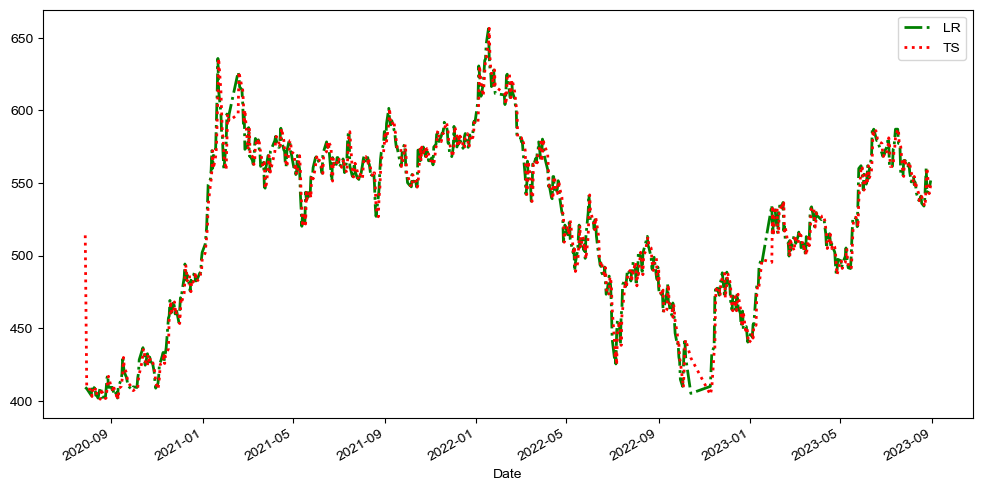

In [90]:
series2['TS'] = model.fittedvalues
series2['LR'] = lr2.coef_ * series['Close'] + lr2.intercept_
series2['LR'].plot(color='green', linestyle='-.', lw=2, legend='LR')
series2['TS'].plot(figsize=(12, 6), color='red', linestyle=':', lw=2, legend='TS')

In [91]:
series2[['TS', 'LR']]

,TS,LR
Date,,
2020-07-28,513.944460,409.293730
2020-07-30,408.520313,408.369340
2020-08-05,407.592127,403.746999
2020-08-06,402.950804,409.293730
2020-08-07,408.520313,407.444830
...,...,...
2023-08-24,548.617317,560.593169
2023-08-25,560.441083,542.930056
2023-08-28,542.705434,545.873878


## AR(1) 殘差(residual)繪圖

<Axes: xlabel='Date'>

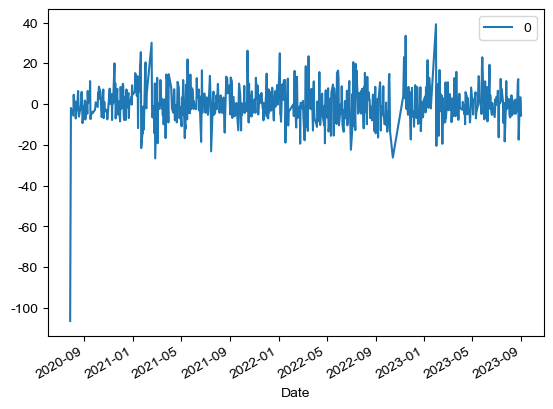

In [92]:
residuals = pd.DataFrame(model.resid)
residuals.plot()

## 資料分割

In [93]:
test_size=12

from sklearn.model_selection import train_test_split

# 資料分割
X_train, X_test = train_test_split(series, test_size=test_size, shuffle=False)

# 查看陣列維度
X_train.shape, X_test.shape

((711, 1), (12, 1))

## 模型訓練、預測與繪圖

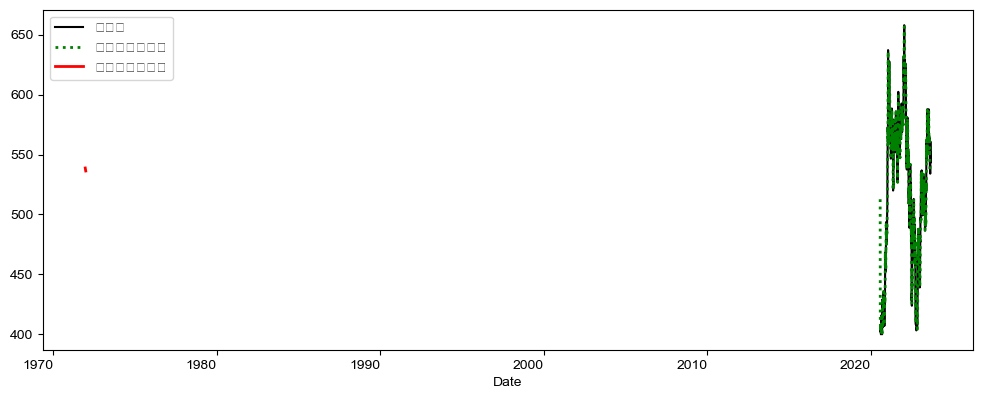

In [95]:
# AR(1) 模型訓練 
ar_1 = ARIMA(X_train[['Close']], order=(1,0,0))
model_1 = ar_1.fit()

# 預測 12 個月
pred = model_1.predict(X_train.shape[0] , X_train.shape[0] + test_size - 1)

# 繪圖
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['axes.unicode_minus'] = False

series['Close'].plot(color='black', linestyle='-', label='實際值')
model_1.fittedvalues.plot(color='green', linestyle=':', lw=2, label='訓練資料預測值')
pred.plot(figsize=(12, 5), color='red', lw=2, label='測試資料預測值')
plt.legend();

# 改用 SARIMAX (Seasonal ARIMA) 演算法

## 一次差分(First-order Differencing)

<Axes: xlabel='Date'>

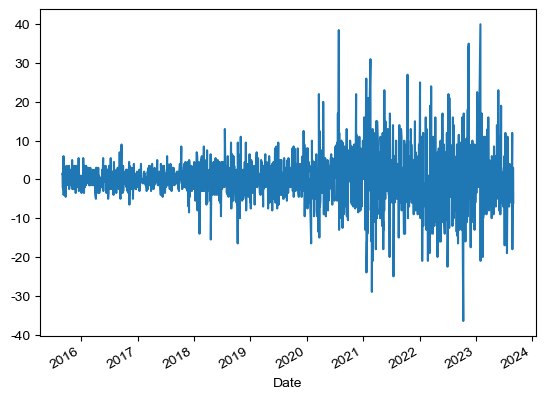

In [96]:
df_diff = df.copy()
df_diff['Close_diff'] = df_diff['Close'] - df_diff['Close'].shift(1)
df_diff.dropna(inplace=True)
df_diff['Close_diff'].plot()

## 使用ADF檢定

In [97]:
result = adfuller(df_diff['Close_diff'])
print(F'ADF統計量: {result[0]}\np value: {result[1]}' + \
      f'\n滯後期數(Lags): {result[2]}\n資料筆數: {result[3]}')

ADF統計量: -26.526900448090938
p value: 0.0
滯後期數(Lags): 2
資料筆數: 1945


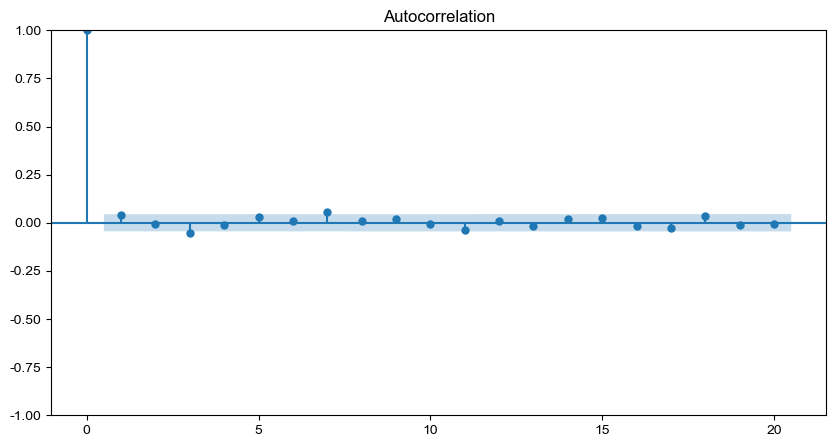

In [98]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plot_acf(df_diff['Close_diff'], lags=20)
fig.set_size_inches(10, 5)

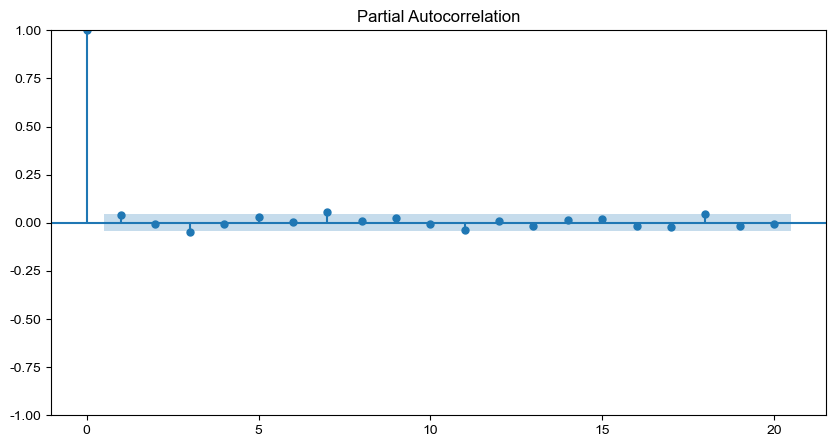

In [99]:
fig = plot_pacf(df_diff['Close_diff'], lags=20, method='ywm')
fig.set_size_inches(10, 5)

## 二次差分(Second-order Differencing)

<Axes: xlabel='Date'>

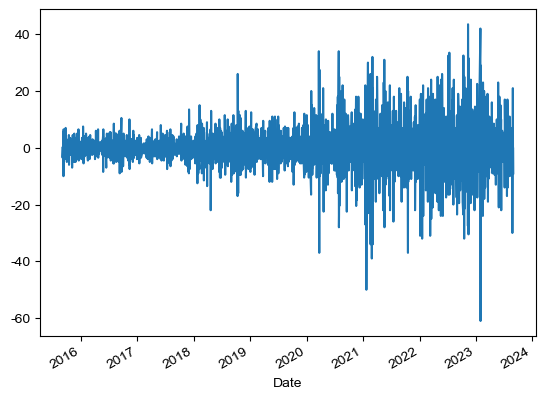

In [100]:
df_diff['Close_diff_2'] = df_diff['Close_diff'] - df_diff['Close_diff'].shift(1) 
df_diff.dropna(inplace=True)

df_diff['Close_diff_2'].plot()

## 使用ADF檢定

In [101]:
result = adfuller(df_diff['Close_diff_2'])
print(F'ADF統計量: {result[0]}\np value: {result[1]}' + \
      f'\n滯後期數(Lags): {result[2]}\n資料筆數: {result[3]}')

ADF統計量: -13.550616392786564
p value: 2.4134730626227176e-25
滯後期數(Lags): 25
資料筆數: 1921


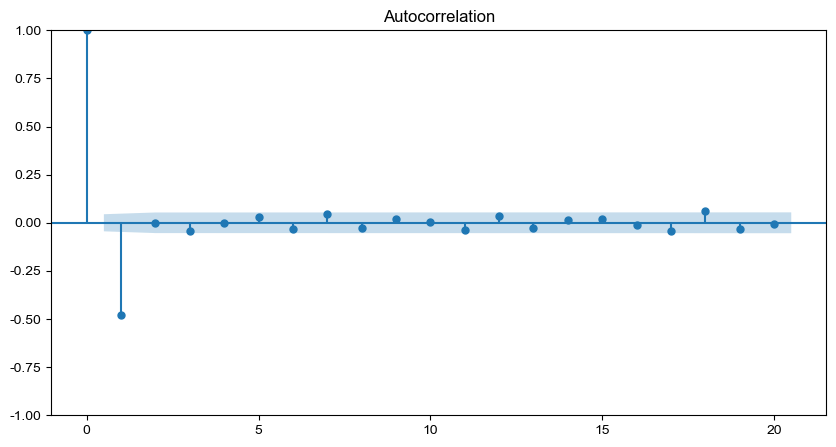

In [102]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plot_acf(df_diff['Close_diff_2'], lags=20)
fig.set_size_inches(10, 5)

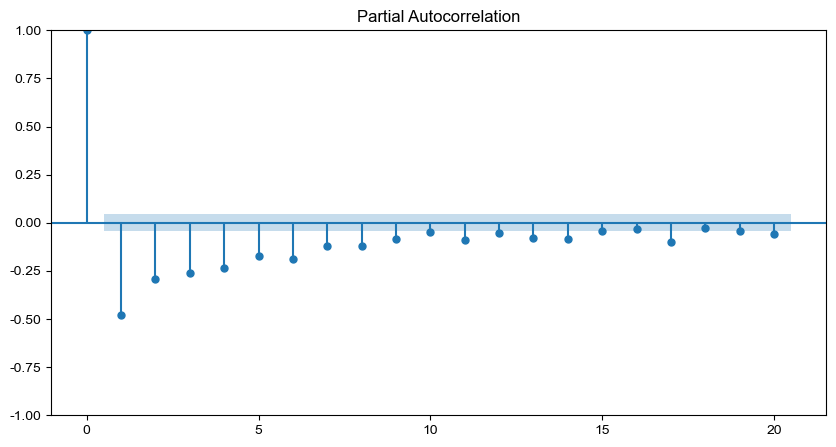

In [103]:
fig = plot_pacf(df_diff['Close_diff_2'], lags=20, method='ywm')
fig.set_size_inches(10, 5)

## SARIMAX

In [104]:
# 資料分割
X_train, X_test = train_test_split(df_diff, test_size=12, shuffle=False)

# SARIMAX
import statsmodels.api as sm
ar_diff=sm.tsa.statespace.SARIMAX(X_train[['Close']],order=(1, 2, 1),seasonal_order=(1,2,1,12))
model_diff=ar_diff.fit()

# 預測 12 個月
pred = model_diff.predict(X_train.shape[0] , X_train.shape[0] + 12 - 1, dynamic= True)
pred

1935    540.774747
1936    542.842889
1937    546.706486
1938    543.390131
1939    534.851736
1940    536.969120
1941    532.714808
1942    524.804057
1943    522.182803
1944    524.608774
1945    520.461470
1946    522.383888
Name: predicted_mean, dtype: float64

In [87]:
df_diff['pred'] = np.concatenate((model_diff.fittedvalues.values, pred.values))
df_diff['pred']

1949-03-01      0.000000
1949-04-01    230.989625
1949-05-01    126.022657
1949-06-01    112.993418
1949-07-01    148.996769
                 ...    
1960-08-01    634.767815
1960-09-01    526.397183
1960-10-01    469.201766
1960-11-01    419.477480
1960-12-01    461.473553
Freq: MS, Name: pred, Length: 142, dtype: float64

## 繪圖

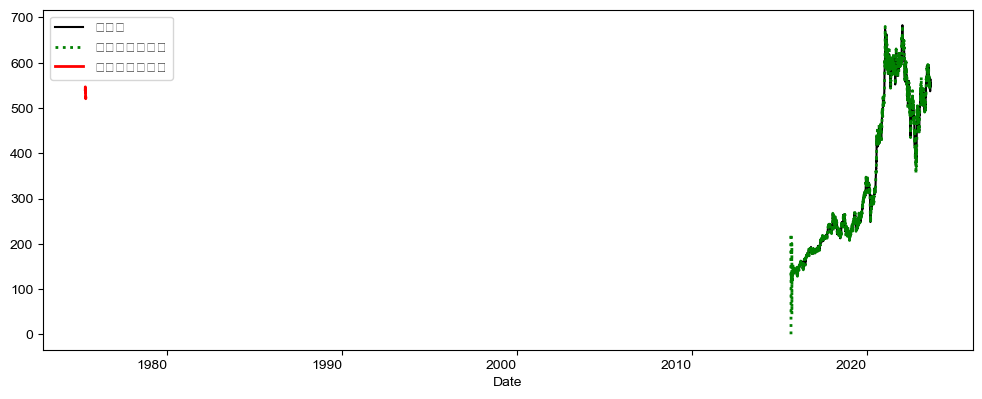

In [106]:
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['axes.unicode_minus'] = False

df_diff['Close'].plot(color='black', linestyle='-', label='實際值')
model_diff.fittedvalues.plot(color='green', linestyle=':', lw=2, label='訓練資料預測值')
pred.plot(figsize=(12, 5), color='red', lw=2, label='測試資料預測值')
plt.legend();

In [107]:
print(f'SARIMAX MSE = {(np.sum(model_diff.resid**2) / len(model_diff.resid)):.2f}')

SARIMAX MSE = 80.27


## 結論：SARIMAX 準確率比迴歸高
### 時間序列 MSE： 80.27， 迴歸 MSE： 5177.87

In [109]:
date1 = pd.date_range(start=df3.index[0], end=df3.index[-1])
df_continue = pd.DataFrame(index=date1)
df_continue = df_continue.join(df3)
df_continue = df_continue.fillna(method='ffill')
df_continue.head()

,Close
2020-07-28,407.542145
2020-07-29,407.542145
2020-07-30,406.605347
2020-07-31,406.605347
2020-08-01,406.605347


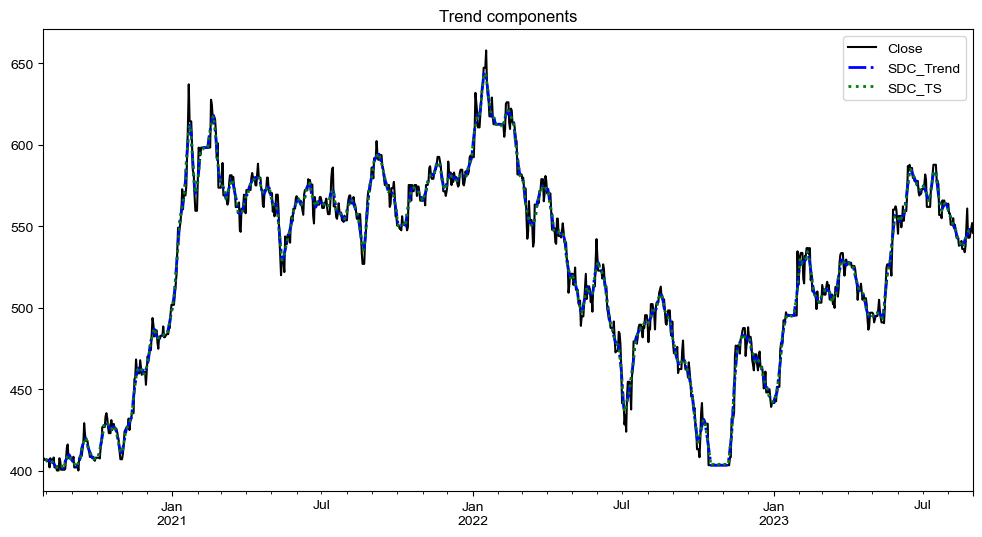

In [110]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = df_continue
s_dc = seasonal_decompose(decomp['Close'], model='additive')
decomp['SDC_Seasonal'] = s_dc.seasonal
decomp['SDC_Trend'] = s_dc.trend
decomp['SDC_Error'] = s_dc.resid
decomp['SDC_TS'] = s_dc.trend + s_dc.seasonal


plt.title('Trend components')
decomp['Close'].plot(figsize=(12, 6), color='black', linestyle='-', legend='Close')
decomp['SDC_Trend'].plot(figsize=(12, 6), color='blue', linestyle='-.', lw=2, legend='SDC_Trend')
decomp['SDC_TS'].plot(figsize=(12, 6), color='green', linestyle=':', lw=2, legend='TS');

## 效應分解(Decomposition)

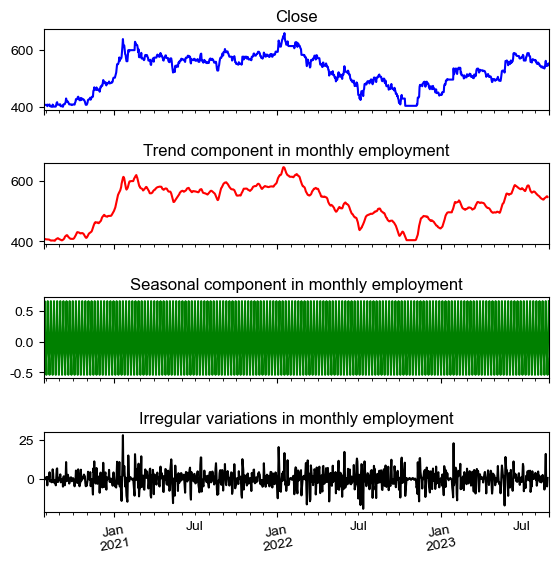

In [112]:
#Plot the original time series, trend, seasonal and random components
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(5.5, 5.5)

decomp['Close'].plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('Close')

pd.Series(data=decomp['SDC_Trend'], index=decomp.index).plot(color='r', linestyle='-', ax=axarr[1])
axarr[1].set_title('Trend component in monthly employment')

pd.Series(data=decomp['SDC_Seasonal'], index=decomp.index).plot(color='g', linestyle='-', ax=axarr[2])
axarr[2].set_title('Seasonal component in monthly employment')

pd.Series(data=decomp['SDC_Error'], index=decomp.index).plot(color='k', linestyle='-', ax=axarr[3])
axarr[3].set_title('Irregular variations in monthly employment')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
fig=plt.xticks(rotation=10)


In [113]:
MSE = (decomp['SDC_Error']**2).sum() / decomp['SDC_Error'].shape[0]
'MSE=', MSE

('MSE=', 26.17969344804292)

## 結論：時間序列預測準確率比迴歸高
### 時間序列 MSE： 26.17， 迴歸 MSE： 5177.87

## 時間序列(seasonal_decompose ) MSE： 26.17 > 時間序列(SARIMAX) MSE： 80.27 > 迴歸 MSE： 5177.87